# Quantization

### Imports

In [0]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.quantization
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.quantization import QuantStub, DeQuantStub
from torch import Tensor
from torchvision import datasets, transforms
import numpy as np
from sklearn import metrics
import math
import os
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
%cd '/content/drive/My Drive/FYP'

device = torch.device('cpu')

/content/drive/My Drive/FYP


### Dataset

In [0]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

### Load model

In [0]:
pretrained_model = 'vanilla_model_4e.pth'

## Quantization-aware training

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    

def train_classifier(cl, opt, x, y):
    x.to(device)
    y.to(device)
    opt.zero_grad()
    pred = cl(x)
    pred.to(device)
    err = criterion(pred, y)
    err.backward()
    opt.step()
    return err, pred

def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

def print_size_of_model(model):
  torch.save(model.state_dict(), 'temp.p')
  print('Size (KB):', os.path.getsize("temp.p")/1e3)
  os.remove('temp.p')

In [0]:
EPOCHS = 4
BATCH_SIZE = 32

qat_model = Classifier().to(device)
qat_model.config = torch.quantization.get_default_qat_qconfig('fbgemm')
# prepare_qat performs the “fake quantization”, preparing the model for quantization-aware training
torch.quantization.prepare_qat(qat_model, inplace=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(qat_model.parameters(), lr=.001, weight_decay=1e-04)

for e in range(EPOCHS):
  qat_model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    error, pred = train_classifier(qat_model, optimizer, data.to(device), target.to(device))
  # Check accuracy after each epoch
  quantized_model = torch.quantization.convert(qat_model.eval(), inplace=False)
  acc = test_model(quantized_model, test_loader)
  print("Epoch ", e, ": Test accuracy: ", 100*acc, "%")
print("Performance in the trained model")
print('Test Accuracy: ', test_model(quantized_model, test_loader)*100, '%')
print("FINISHED!!!")

/usr/local/lib/python3.6/dist-packages/torch/quantization/quantize.py:147: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "


Epoch  0 : Test accuracy:  96.82 %
Epoch  1 : Test accuracy:  97.14 %
Epoch  2 : Test accuracy:  97.63 %
Epoch  3 : Test accuracy:  98.02 %
Performance in the trained model
Test Accuracy:  98.02 %
FINISHED!!!


In [0]:
torch.save(qat_model.state_dict(), 'qat_model_wd_1e-04.pth')

## Post-training static quantization

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)

        # Insert QuantStub and DeQuantStub at the beginning and end of the network.
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        

    def forward(self, x):
        x = self.quant(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.reshape(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return self.dequant(x)
    

def train_classifier(cl, opt, x, y):
    x.to(device)
    y.to(device)
    opt.zero_grad()
    pred = cl(x)
    pred.to(device)
    err = criterion(pred, y)
    err.backward()
    opt.step()
    return err, pred

def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

def print_size_of_model(model):
  torch.save(model.state_dict(), 'temp.p')
  print('Size (KB):', os.path.getsize("temp.p")/1e3)
  os.remove('temp.p')

# Substitute for the log_softmax(x, dim=1) and F.nll_loss(pred, y) due to CPU constraints
criterion = nn.CrossEntropyLoss()

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

# Print size and accuracy of the model
print(model)
print_size_of_model(model)
print('Test Accuracy: ', test_model(model, test_loader)*100, '%')

Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)
Size (KB): 1098.462
Test Accuracy:  98.76 %


In [0]:
model.qconfig = torch.quantization.default_qconfig
print(model.qconfig)
torch.quantization.prepare(model, inplace=True)

# Calibrate with the training set
test_model(model, train_loader)
print('Post Training Quantization: Calibration done')

# Convert to quantized model
torch.quantization.convert(model, inplace=True)
print('Post Training Quantization: Convert done')
q_acc = test_model(model, test_loader)
print('Quantized evaluation accuracy: ',q_acc*100, '%')
print_size_of_model(model)

# Save model
torch.save(model.state_dict(), 'post-training_static_quantization.p')

QConfig(activation=functools.partial(<class 'torch.quantization.observer.MinMaxObserver'>, reduce_range=True), weight=functools.partial(<class 'torch.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric))
Post Training Quantization: Calibration done
Post Training Quantization: Convert done
Quantized evaluation accuracy:  98.77 %
Size (KB): 279.548


In [0]:
model

Classifier(
  (conv1): QuantizedConv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), scale=0.05616486072540283, zero_point=63)
  (conv2): QuantizedConv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), scale=0.10477986931800842, zero_point=86)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): QuantizedLinear(
    in_features=320, out_features=512, scale=0.1416749656200409, zero_point=77
    (_packed_params): LinearPackedParams()
  )
  (fc2): QuantizedLinear(
    in_features=512, out_features=200, scale=0.17969848215579987, zero_point=63
    (_packed_params): LinearPackedParams()
  )
  (fc3): QuantizedLinear(
    in_features=200, out_features=10, scale=0.4438689947128296, zero_point=67
    (_packed_params): LinearPackedParams()
  )
  (quant): Quantize(scale=tensor([0.0157]), zero_point=tensor([64]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

# FGSM

### Inputs

In [0]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

# MNIST Test dataset and dataloader declaration designed for FGSM
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

### FGSM attack

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

### Run attack

In [0]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss: CrossEntropyLoss()
        loss = criterion(output, target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [0]:
accuracies = []
examples = []
model = qat_model 

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
print(accuracies)

### Results

In [0]:
# Weight decay vanilla quantized
qat_fgsm_wd = np.mean([
              [0.981, 0.9441, 0.8589, 0.7187, 0.524, 0.3239, 0.1707],
              [0.9759, 0.912, 0.7855, 0.5975, 0.3931, 0.2241, 0.1149],
              [0.9864, 0.9462, 0.8635, 0.7056, 0.49, 0.2647, 0.1121],
              [0.9826, 0.927, 0.8186, 0.6553, 0.4502, 0.2764, 0.1708],

], axis=0)

qat_fgsm_wd

array([0.981475, 0.932325, 0.831625, 0.669275, 0.464325, 0.272275,
       0.142125])

In [0]:
# vanilla quantized 
qat_fgsm_vanilla = np.mean([
                    [0.9842, 0.9473, 0.8759, 0.7567, 0.5967, 0.4183, 0.2671],
                    [0.954, 0.8558, 0.7076, 0.5416, 0.3938, 0.2747, 0.1793],
                    [0.9755, 0.8997, 0.7471, 0.5297, 0.3377, 0.206, 0.1243],
                    [0.9844, 0.9329, 0.8352, 0.6801, 0.4743, 0.2658, 0.1302],
                    [0.9829, 0.9386, 0.8416, 0.6959, 0.5223, 0.3501, 0.2059],
                    [0.9863, 0.9483, 0.8733, 0.7314, 0.5171, 0.2983, 0.1428],
                    [0.9819, 0.9242, 0.7959, 0.5962, 0.3829, 0.2004, 0.1011]
], axis=0)

qat_fgsm_vanilla

array([0.97845714, 0.92097143, 0.81094286, 0.64737143, 0.46068571,
       0.28765714, 0.16438571])

In [0]:
# vanilla
fgsm_vanilla = np.mean([
                [0.9766, 0.8948, 0.7273, 0.513, 0.3179, 0.1715, 0.097],
                [0.9833, 0.9269, 0.8139, 0.6432, 0.442, 0.2653, 0.1508], 
                [0.9764, 0.9149, 0.7944, 0.6132, 0.3927, 0.2049, 0.084],
                [0.9786, 0.9164, 0.8027, 0.6301, 0.4327, 0.2578, 0.1436],
                [0.9793, 0.9293, 0.825, 0.6513, 0.4297, 0.2406, 0.1283]
], axis=0)

fgsm_vanilla

array([0.97884, 0.91646, 0.79266, 0.61016, 0.403  , 0.22802, 0.12074])

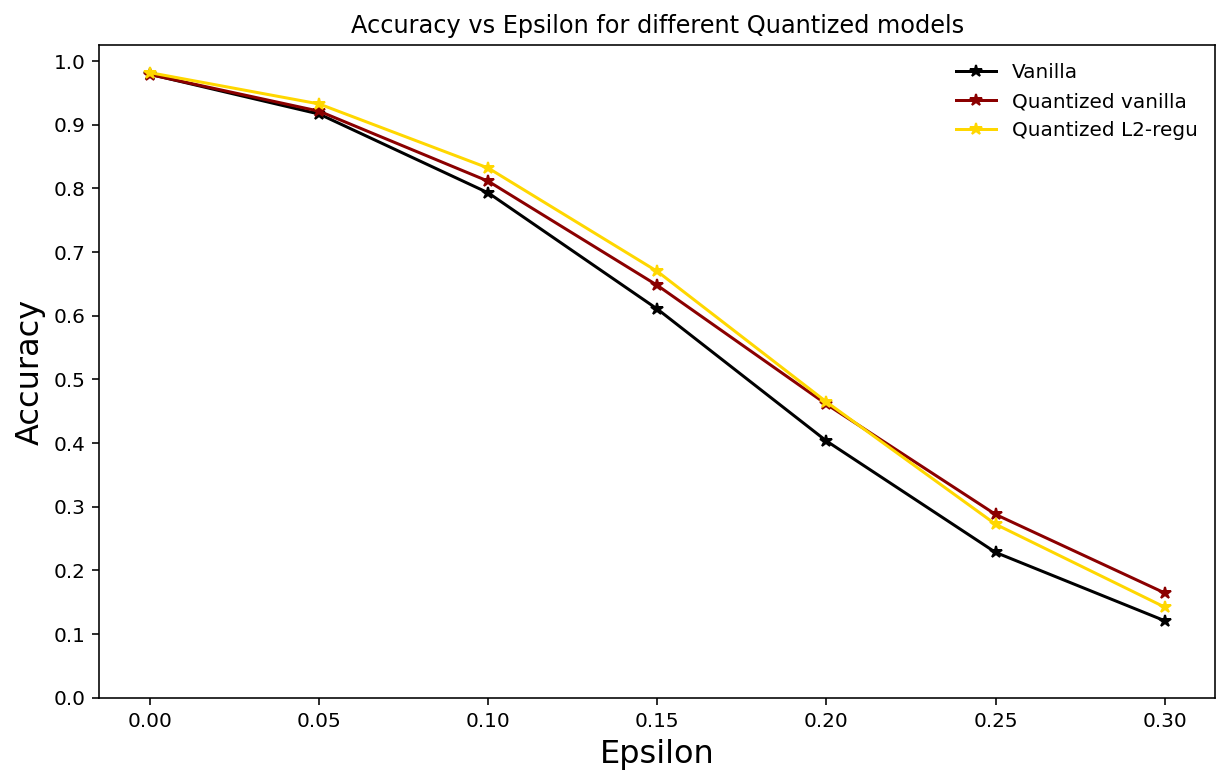

In [0]:
# plot the quantized accuracies vs epsilon
fgsm_data = {'Vanilla': fgsm_vanilla, 
             'Quantized vanilla': qat_fgsm_vanilla,
             'Quantized L2-regu': qat_fgsm_wd,
             }

plt.figure(figsize=(10,6))
colors =  ['black', 'darkred', 'gold', 'chartreuse', 'lightseagreen', 'blue', 'magenta']

for idx, (name, results) in enumerate(fgsm_data.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label="{}".format(name))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon for different Quantized models")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

# bla

In [0]:
from collections import OrderedDict
state_dict = torch.load(pretrained_model)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
  print(k)
  print(v)